In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets


# 1. 장치 설정
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 2. 하이퍼파라미터 및 transorm
hyperparams = {
    "batch_size": 16,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224), # VGG-16 모델은 224x224 크기의 이미지로 학습한 모델이므로 입력 이미지의 크기도 224x224 크기로 변형
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}

# 3. 데이터세트 로드
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=hyperparams["transform"],
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=hyperparams["transform"],
)

train_dataloader = DataLoader(training_data, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cuda device
Shape of X [N, C, H, W]: torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16]) torch.int64


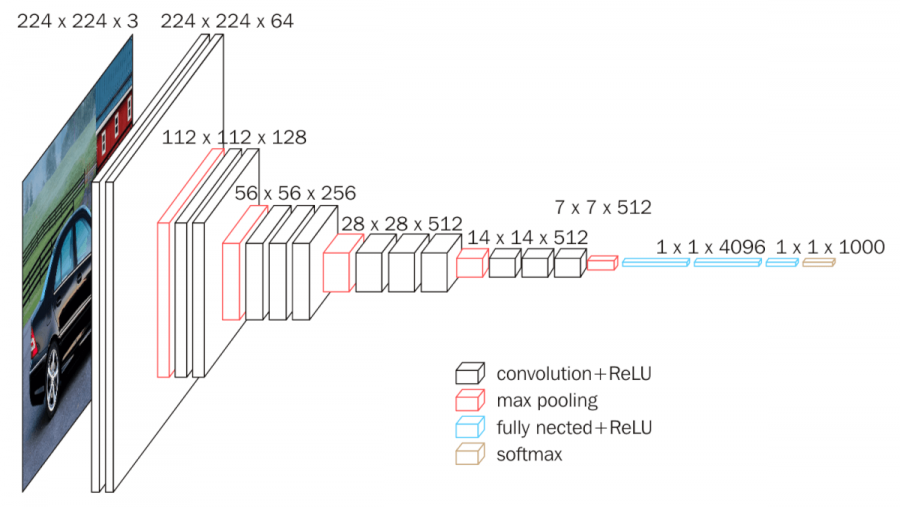

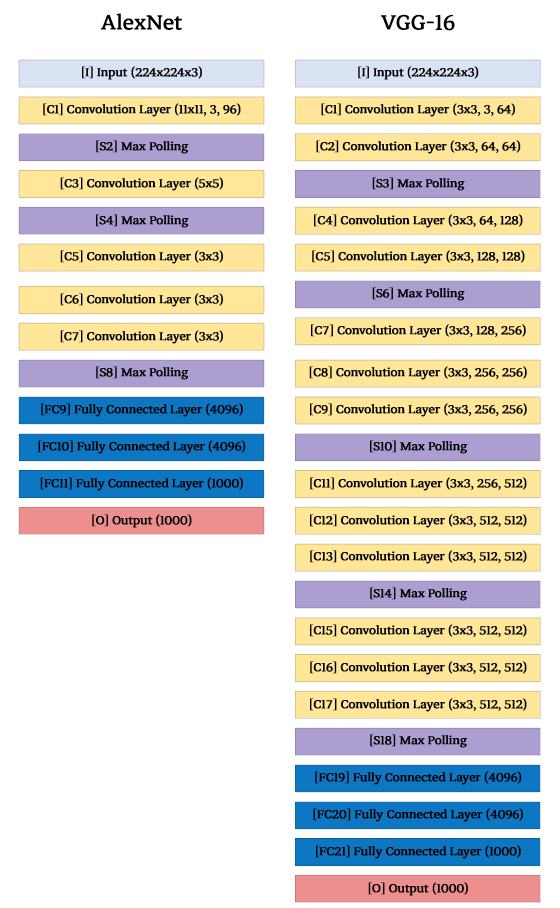

In [2]:
# 4. VGG-16 모델 정의
# VGG-16 아키텍처
cfg = {
    'VGG16': [64, 64, 'M',
              128, 128, 'M',
              256, 256, 256, 'M',
              512, 512, 512, 'M',
              512, 512, 512, 'M']
}

class VGG(nn.Module):
    def __init__(self, vgg_name='VGG16', num_classes=10):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])

        # 분류기 정의 (위 그림의 FC19, 20, 21)
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    # Conv, ReLU, MaxPooling
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3 # CIFAR10은 3개의 채널(RGB)
        for v in cfg:
            if v == 'M': # MaxPooling 단계
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # VGG에서는 둘 다 2로 사용한다.
            else:
                # conv 단계 정의
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                # BN, ReLU도 추가
                layers += [conv2d,
                           nn.BatchNorm2d(v),
                           nn.ReLU(inplace=True)]
                in_channels = v # 다음 반복에서의 입력 채널 크기
        return nn.Sequential(*layers) # 위 과정을 Sequential 단계에 모두 담기


    # 최종 순전파 과정
    def forward(self, x):
        x = self.features(x)    # (batch_size(64), 512, 7, 7)
        x = torch.flatten(x, 1) # FC에 넣기 위해 평탄화 -> (batch_size(64), 512*7*7)
        x = self.classifier(x)  # 최종 분류기에 넣기
        return x

In [3]:
# 5. 모델, 손실 함수, 옵티마이저 초기화
model = VGG(vgg_name='VGG16', num_classes=10).to(device)
criterion = nn.CrossEntropyLoss() # 클래스 문제
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])

In [5]:
# 6. 모델 학습
for epoch in range(hyperparams["epochs"]):
    model.train() # 모델을 학습 모드로 설정
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 가중치 초기화, 역전파, 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0: # 100 배치마다 로그 출력
            print(f"Epoch [{epoch+1}/{hyperparams['epochs']}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    print(f'--- Epoch {epoch+1} Average Loss: {running_loss / len(train_dataloader):.4f} ---')

Epoch [1/5], Step [100/3125], Loss: 1.9976
Epoch [1/5], Step [200/3125], Loss: 2.1325
Epoch [1/5], Step [300/3125], Loss: 1.8988
Epoch [1/5], Step [400/3125], Loss: 1.9572
Epoch [1/5], Step [500/3125], Loss: 2.2056
Epoch [1/5], Step [600/3125], Loss: 1.8240
Epoch [1/5], Step [700/3125], Loss: 1.9242
Epoch [1/5], Step [800/3125], Loss: 2.0197
Epoch [1/5], Step [900/3125], Loss: 1.6547
Epoch [1/5], Step [1000/3125], Loss: 1.7100
Epoch [1/5], Step [1100/3125], Loss: 1.5308
Epoch [1/5], Step [1200/3125], Loss: 1.7835
Epoch [1/5], Step [1300/3125], Loss: 1.6771
Epoch [1/5], Step [1400/3125], Loss: 1.5000
Epoch [1/5], Step [1500/3125], Loss: 1.5346
Epoch [1/5], Step [1600/3125], Loss: 1.9248
Epoch [1/5], Step [1700/3125], Loss: 2.1765
Epoch [1/5], Step [1800/3125], Loss: 1.3002
Epoch [1/5], Step [1900/3125], Loss: 1.4679
Epoch [1/5], Step [2000/3125], Loss: 1.7134
Epoch [1/5], Step [2100/3125], Loss: 1.3900
Epoch [1/5], Step [2200/3125], Loss: 1.7280
Epoch [1/5], Step [2300/3125], Loss: 1.57

In [7]:
# 7. 모델 평가
from torch.nn import functional as F

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_labels = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(labels, outputs_labels).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 76.97%


5번의 Epoch 결과  
Average Loss: 0.6877  
accuracy: 0.7697